In [17]:
from zipfile import ZipFile
import os

#change directory
os.chdir('/content/')

#unzip the archive
local_zip = './cats_and_dogs_filtered.zip'
zip_ref = ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [18]:
import os 

base_dir = 'cats_and_dogs_filtered'
print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['vectorize.py', 'validation', 'train']

Contents of train directory:
['dogs', 'cats']

Contents of validation directory:
['dogs', 'cats']


You can assign each of these directories to a variable so you can use it later

In [19]:
import os

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

#Directory with training cat/dog pics
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

#directory with validation cat/dog pictures 
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

Now see what the file names look like in catas and dogs train directories (file naming conventions are the same in validaiton directory)

In [20]:
train_cat_fnames = os.listdir( train_cats_dir)
train_dog_fnames = os.listdir( train_dogs_dir)

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['cat.349.jpg', 'cat.672.jpg', 'cat.355.jpg', 'cat.618.jpg', 'cat.326.jpg', 'cat.737.jpg', 'cat.539.jpg', 'cat.870.jpg', 'cat.934.jpg', 'cat.956.jpg']
['dog.628.jpg', 'dog.575.jpg', 'dog.817.jpg', 'dog.962.jpg', 'dog.50.jpg', 'dog.26.jpg', 'dog.847.jpg', 'dog.839.jpg', 'dog.181.jpg', 'dog.204.jpg']


Let's find out the total number of cat and dog image in the train and validation directories 

In [23]:
print('Total training cat images:', len(os.listdir( train_cats_dir )))
print('Total training dog images:', len(os.listdir( train_dogs_dir )))

print('Total validation cat images:', len(os.listdir( validation_cats_dir )))
print('Total validation dog images:', len(os.listdir( validation_dogs_dir )))

Total training cat images: 1000
Total training dog images: 1000
Total validation cat images: 500
Total validation dog images: 500


Now take a look at a few pics to get a better sense of what the cat and dog datasets look like

First configure the matplotlib parameters:

In [24]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#parameter for our graph; We'll output images in a 4 x 4 configuration
nrows = 4
ncols = 4

pic_index = 0 #index for iterating over images

Now display a batch of 8 cat and 8 dog pics

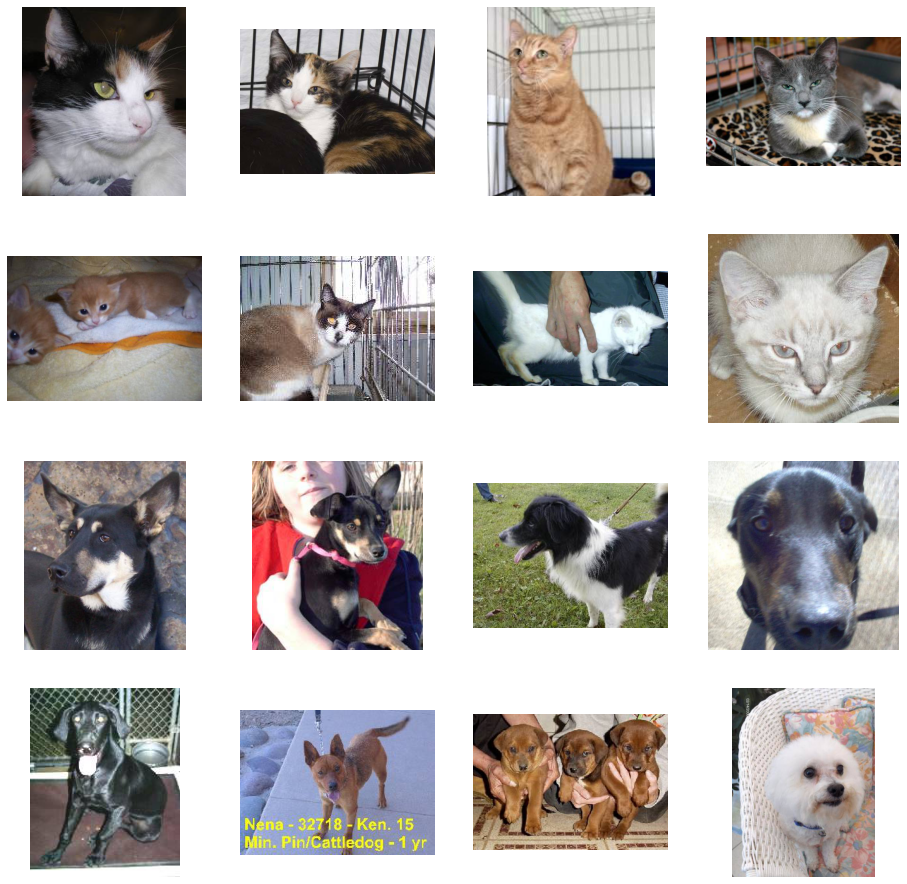

In [25]:
#Set up matplotlib fig and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8

next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[ pic_index - 8 : pic_index]
              ]

next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[ pic_index - 8 : pic_index]
              ]

for i, img_path in enumerate(next_cat_pix + next_dog_pix):
  #set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') #don't show axis or grid lines

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

You can see from the images that they come in many different shapes and sizes. To train a neural network to handle the image, you'll need to tweak the images 

Building a small model from scratch to get to about 72% accuracy

To train a neural network to handle the images, you'll need them to be a uniform size. You will choose 150x150 pixels for this 

You can define the model through TensorFlow 

In [26]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    #Flatten the results to feed them into the Dense Neural Nodes
    tf.keras.layers.Flatten(),
    #512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    #Only 1 output neuron using sigmoid function (0-1)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 74, 74, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 64)      

Next you'll configure the specifications for model training. You will train the model with the binary_crossentropy loss, becasue it's a binary classification problem and your final activation is a sigmoid

We will use the RMSprop optimizer with a learning rate of 0.001

In [28]:
from tensorflow.keras.optimizers import RMSprop

model.compile(optimizer = RMSprop(learning_rate = 0.001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])


Data Pre-Processing:

Next step is to setup the data generators that will read pics in the source folders, convert them to float32 tensors, and feed them (with their labels) to the model.

One generator will be for the training images and another for the validation (aka test) images. These generators will yield batches of images of size 150x150 and their labels (binary)

The data will also be normalized so that it is more amenable to processing by the network. You will preprocess the images by normalizing the pixel values to be in the [0,1] range (originally the vales are in the [0, 255] range)

In keras, this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory)

In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#all images will be rescaled by 1/255
train_datagen = ImageDataGenerator( rescale = 1/255)
test_datagen = ImageDataGenerator( rescale = 1/255)

#Flow training images in abtches of 20 using train_datagen generator 
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size = (150, 150),
                                                    batch_size = 20,
                                                    class_mode = 'binary')

validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                         target_size = (150, 150),
                                                         batch_size = 20,
                                                         class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Training:

Now train on all 2,000 images available for 15 epochs and monitor the accuracy in the validation set 

In [30]:
#Creating a callback 

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    #check accuracy
    accuracy_value = 0.99
    if(logs.get('accuracy') > accuracy_value):

      print(f'\nAccuracy is more than {accuracy_value} so cancelling training.')
      self.model.stop_training = True

callbacks = myCallback()

In [32]:
history = model.fit(
            train_generator,
            steps_per_epoch=100,
            epochs=15,
            validation_data=validation_generator,
            validation_steps=50,
            verbose=2,
            callbacks=[callbacks]
            )

Epoch 1/15
100/100 - 53s - loss: 0.6133 - accuracy: 0.6850 - val_loss: 0.5718 - val_accuracy: 0.6980 - 53s/epoch - 531ms/step
Epoch 2/15
100/100 - 53s - loss: 0.5281 - accuracy: 0.7315 - val_loss: 0.5568 - val_accuracy: 0.7150 - 53s/epoch - 532ms/step
Epoch 3/15
100/100 - 54s - loss: 0.4531 - accuracy: 0.7875 - val_loss: 0.5949 - val_accuracy: 0.6990 - 54s/epoch - 541ms/step
Epoch 4/15
100/100 - 54s - loss: 0.3856 - accuracy: 0.8370 - val_loss: 0.5889 - val_accuracy: 0.7320 - 54s/epoch - 536ms/step
Epoch 5/15
100/100 - 53s - loss: 0.2991 - accuracy: 0.8650 - val_loss: 0.6415 - val_accuracy: 0.7250 - 53s/epoch - 531ms/step
Epoch 6/15
100/100 - 53s - loss: 0.2247 - accuracy: 0.9045 - val_loss: 0.7215 - val_accuracy: 0.7470 - 53s/epoch - 533ms/step
Epoch 7/15
100/100 - 54s - loss: 0.1478 - accuracy: 0.9430 - val_loss: 1.0063 - val_accuracy: 0.6880 - 54s/epoch - 543ms/step
Epoch 8/15
100/100 - 54s - loss: 0.1231 - accuracy: 0.9605 - val_loss: 1.4157 - val_accuracy: 0.6880 - 54s/epoch - 542

Visualizing intermediate representations:

You can pick a random image from the training set and generate a figure where each row is the output of a layer and each image in the row is a specific filter in tha touput feature map 

In [ ]:
import numpy as np
import random 
from tensorflow.keras.preprocessing.image import img_to_array, load_img

#define a new model that will take an image as input and will output 
#intermediate representations for all layers in the previous model

successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

#Prepare a random input image from the training set
cat_img_files = [os.path.join(train_cats_dir, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dogs_dir, f) for f in train_dog_fnames]
img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size = (150, 150)) #This is a PIL image
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

#Scale by 1/255 (normalize)
x /= 255.0

#run the image through the network and obtain the intermediate representations for the image
successive_feature_maps = visualization_model.predict(x)

#These are the names of the layers so you can have them as part of the plot 
layer_names = [layer.name for layer in model.layers]

#Display the representations 
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

  if len(feature_map.shape) == 4:

    #Just do this for the conv / max pool layers 
    n_features = feature_map.shape[-1] #number of features in the feature map
    size       = feature_map.shape[ 1] #feature map shape (1, size, size, n_features)

    #Title the images in the matrix 
    display_grid = np.zeros((size, size * n_features))

    #Postprocess the feature to be visually palatable

  for i in range(n_features):
    x  = feature_map[0, :, :, i]
    x -= x.mean()
    x /= x.std()
    x *= 64
    x += 128
    x  = np.clip(x, 0, 255).astype('uint8')
    display_grid[:, i * size : (i + 1) * size] = x #tile each filter into a horizontal grid

    #Display the grid
    scale = 20. / n_features
    plt.figure( figsize = (scale * n_features, scale) )
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

Evaluating accuracy and loss for the model

Plot the training/validation accuracy and loss as collected during training

Text(0.5, 1.0, 'Training and Validation Loss')

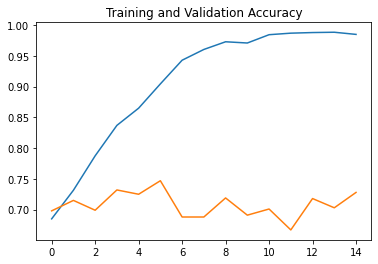

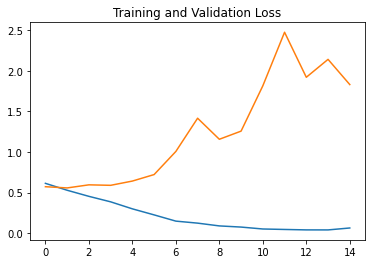

In [40]:
#Retrieve list of results on training and test data set for each epoch
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc))

#plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and Validation Accuracy')
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and Validation Loss')